<a href="https://colab.research.google.com/github/vard-uhi/Customer-Segmentation/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Clustering Travel Agency Booking Data**

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import pylab as pl
from scipy import stats
from sklearn.externals.six import StringIO
from sklearn import preprocessing
from sklearn import cluster, tree, decomposition
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pydot
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
#load the data
from google.colab import files
data_to_load = files.upload()

Saving travel - travel.csv to travel - travel.csv


In [27]:
import io
raw_data = pd.read_csv(io.BytesIO(data_to_load['travel - travel.csv']))

In [28]:
df = raw_data.copy()

In [29]:
# Preview our data
df.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68
1,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37
2,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22
3,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42
4,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83


In [30]:
# Get some base information on our dataset
print ("Rows     : " , df.shape[0])
print ("Columns  : " , df.shape[1])
print ("\nFeatures : \n" , df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n", df.nunique())

Rows     :  100000
Columns  :  24

Features : 
 ['date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']

Missing values :   36329

Unique values :  
 date_time                    99886
site_name                       41
posa_continent                   5
user_location_country          201
user_location_region           779
user_location_city           10779
orig_destination_distance    62206
user_id                      88863
is_mobile                        2
is_package                       2
channel                         11
srch_ci                       1066
srch_co                       1068
srch_adults_cnt                 10
srch

In [31]:
# Get statistics for our Numerical Columns
df.describe() 

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,63915.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,9.838570,2.678150,85.995070,308.636990,27676.391240,1960.661721,6.054383e+05,0.133770,0.248140,5.858590,2.020710,0.336750,1.111750,14426.32738,2.577290,0.079930,1.487980,3.150920,81.093290,598.848330,49.860370
std,11.996426,0.749018,59.292002,208.706581,16768.647409,2228.153377,3.516154e+05,0.340407,0.431936,3.722823,0.909774,0.734449,0.451602,11036.98122,2.149263,0.271186,1.280262,1.620534,56.111519,510.959297,28.885423
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.005600,1.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,66.000000,174.000000,12949.000000,312.792100,2.987962e+05,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,8267.00000,1.000000,0.000000,1.000000,2.000000,50.000000,158.000000,25.000000
50%,2.000000,3.000000,66.000000,314.000000,27655.000000,1131.835300,6.028825e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,9145.00000,1.000000,0.000000,1.000000,2.000000,50.000000,591.000000,49.000000
75%,15.000000,3.000000,70.000000,385.000000,42328.000000,2542.359350,9.157222e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,18784.00000,5.000000,0.000000,2.000000,4.000000,106.000000,701.000000,73.000000
max,53.000000,4.000000,239.000000,1025.000000,56507.000000,11965.376100,1.198783e+06,1.000000,1.000000,10.000000,9.000000,9.000000,8.000000,65035.00000,9.000000,1.000000,120.000000,6.000000,212.000000,2117.000000,99.000000


In [32]:
# Find where the missing values are located
df.isnull().sum()

date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    36085
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                        122
srch_co                        122
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
dtype: int64

In [33]:
# Create our Corelation Matrix
corr = df.corr()
corr

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
site_name,1.000000,-0.637743,0.159283,0.130818,-0.013471,0.027609,0.030404,-0.005418,0.048820,-0.027780,-0.013405,-0.031962,0.016585,0.034895,-0.006934,-0.013460,0.022274,0.201760,0.263167,-0.068316,-0.026689
posa_continent,-0.637743,1.000000,0.179726,-0.034647,0.039227,0.049808,-0.015209,0.016331,-0.093459,0.089680,0.012350,0.034453,-0.033712,-0.015535,0.037172,0.013319,-0.018952,-0.333578,-0.156578,0.049214,0.018297
user_location_country,0.159283,0.179726,1.000000,0.058496,0.122686,0.047689,-0.021091,0.003728,-0.025284,0.109999,0.042526,0.037101,0.000858,0.013486,0.028888,0.001284,0.003539,-0.063744,0.097624,0.015569,-0.011876
user_location_region,0.130818,-0.034647,0.058496,1.000000,0.132457,0.136560,0.002225,0.016982,0.040482,-0.001600,0.005487,0.014009,0.000254,0.022567,0.001376,0.000253,-0.007570,0.043027,-0.050301,0.040367,0.004984
user_location_city,-0.013471,0.039227,0.122686,0.132457,1.000000,0.014178,-0.007989,-0.003741,0.013032,0.023497,0.006628,0.002638,-0.000694,0.000786,-0.004399,-0.002655,-0.002175,0.007759,-0.001987,0.008558,0.000102
orig_destination_distance,0.027609,0.049808,0.047689,0.136560,0.014178,1.000000,0.017015,-0.059464,0.041991,-0.000398,-0.024039,-0.059722,-0.012484,-0.036314,-0.042859,-0.033480,0.009483,0.416180,0.254321,-0.090112,0.003624
user_id,0.030404,-0.015209,-0.021091,0.002225,-0.007989,0.017015,1.000000,-0.011439,-0.018901,-0.003593,-0.007370,0.002983,-0.001625,0.002716,0.007133,0.001561,0.001355,0.002447,0.008707,-0.002463,0.003202
is_mobile,-0.005418,0.016331,0.003728,0.016982,-0.003741,-0.059464,-0.011439,1.000000,0.046903,-0.030770,0.016661,0.018211,-0.022565,-0.007140,-0.016039,-0.028623,0.008084,-0.024144,-0.029574,0.007644,0.012145
is_package,0.048820,-0.093459,-0.025284,0.040482,0.013032,0.041991,-0.018901,0.046903,1.000000,-0.011269,-0.024097,-0.037673,-0.036653,-0.146647,-0.224422,-0.081307,0.126500,0.108993,-0.044426,-0.014636,0.031399
channel,-0.027780,0.089680,0.109999,-0.001600,0.023497,-0.000398,-0.003593,-0.030770,-0.011269,1.000000,-0.014931,0.004202,0.010191,-0.000392,0.021612,0.025697,-0.010248,-0.022241,-0.001217,0.006164,0.002596


Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

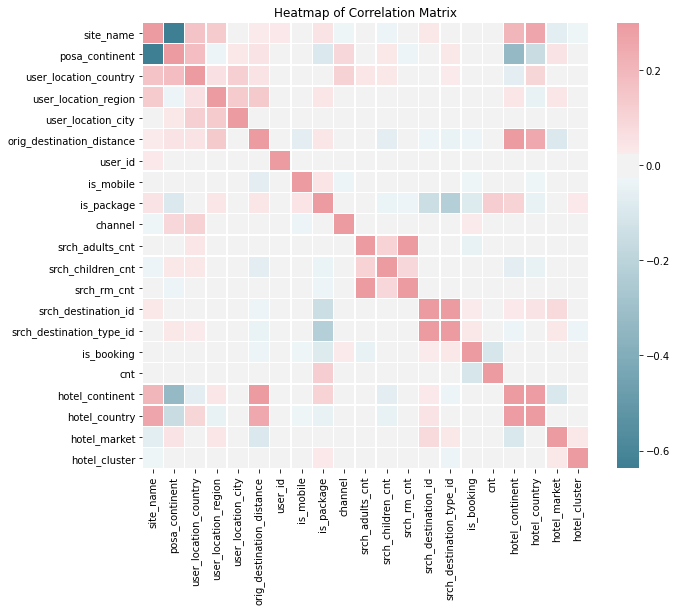

In [34]:
# Generate our corelation plot or heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220,10,as_cmap = True)

sns.heatmap(corr,xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,cmap=cmap,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

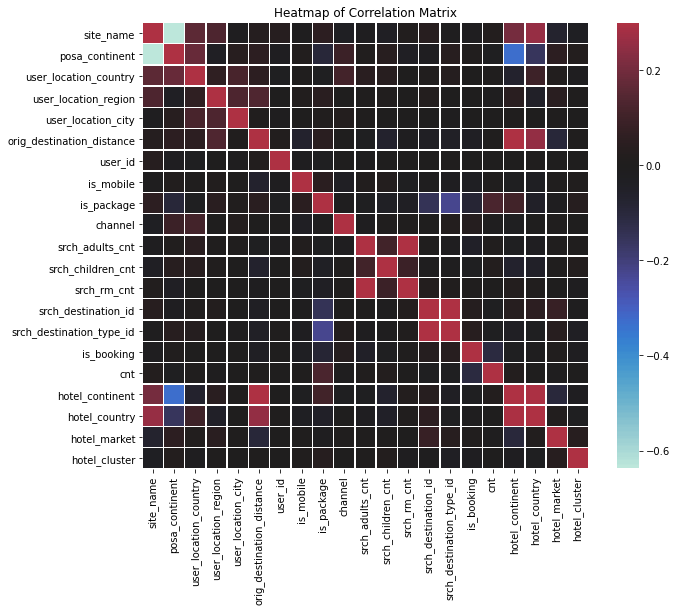

In [35]:
# Generate our corelation plot or heatmap
plt.figure(figsize = (10,10))
#cmap = sns.diverging_palette(220,10,as_cmap = True)

sns.heatmap(corr,xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03cc828e80>,
      dtype=object)

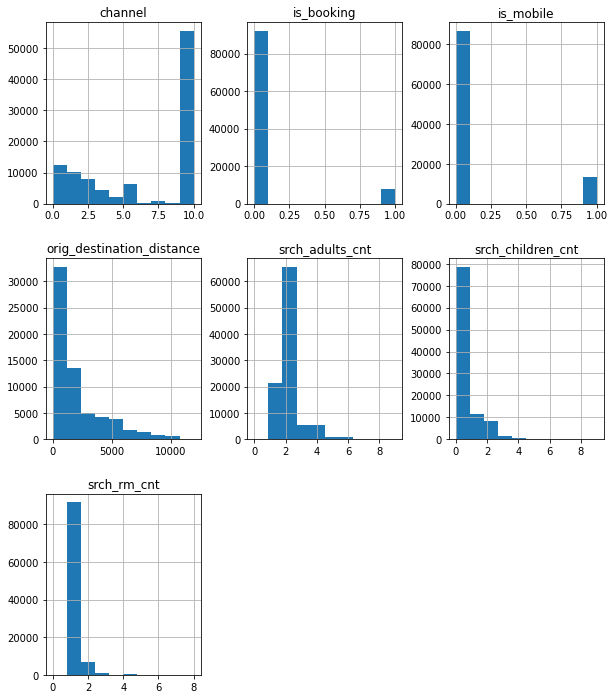

In [36]:
# Plot some of the data

df[['channel', 'is_booking', 'is_mobile', 'orig_destination_distance', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt']].hist(figsize=(10,12))

In [42]:
booking_count_per_user = df.groupby('user_id')['is_booking'].agg(['count']).reset_index()
booking_count_per_user.head()

,user_id,count
0,14,1
1,38,1
2,40,1
3,156,2
4,160,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03cc40a828>]],
      dtype=object)

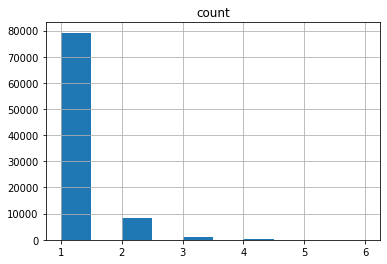

In [43]:
booking_count_per_user[['count']].hist(figsize=(6,4))

In [44]:
# Consilidate by user IDs
df.groupby('user_id')['is_booking'].agg(['count']).head()

,count
user_id,
14,1
38,1
40,1
156,2
160,1


In [45]:
# Merge this with our original dataframe to add our 'count' column
# default ‘inner’, merging on user_id
df = df.merge(df.groupby('user_id')['is_booking'].agg(['count']).reset_index())
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,count
0,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2
1,2014-07-28 23:50:54,24,2,77,871,36643,454.4611,792280,0,1,9,2014-08-26,2014-08-31,1,0,1,8286,1,0,1,0,63,1258,14,2
2,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1
3,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1
4,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2


#### Now let's do some Logic Checks

In [46]:
#number of guests (number of travelers) need to be > 0
# We use crosstab to group the counts
pd.crosstab(df['srch_adults_cnt'], df['srch_children_cnt'])

srch_children_cnt,0,1,2,3,4,5,6,7,8,9
srch_adults_cnt,,,,,,,,,,
0,174,2,3,2,0,0,0,0,0,0
1,18749,2137,523,117,11,1,9,1,2,0
2,50736,7093,6529,972,208,14,7,1,0,0
3,3645,1131,469,131,27,5,2,2,0,2
4,3933,690,494,77,83,9,4,0,0,0
5,535,131,41,20,6,4,2,0,0,0
6,669,73,53,28,18,13,7,0,0,0
7,99,20,5,8,6,3,0,0,0,0
8,183,12,13,2,6,1,3,2,2,1


In [47]:
# Then we sum the counts of travellers and drop the rows that area equal to zero
df.drop(df[df['srch_adults_cnt'] + df['srch_children_cnt'] == 0].index).head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,count
0,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2
1,2014-07-28 23:50:54,24,2,77,871,36643,454.4611,792280,0,1,9,2014-08-26,2014-08-31,1,0,1,8286,1,0,1,0,63,1258,14,2
2,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1
3,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1
4,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2


In [48]:
# Changing the column type to  datatime type using pandas
df['srch_co'] = pd.to_datetime(df['srch_co'])
df['srch_ci'] = pd.to_datetime(df['srch_ci'])
df['date_time'] = pd.to_datetime(df['date_time'])

# Change the timestamp of 'date_time' (2014-11-03 16:02:28) to simply "2014-11-03"
df['date'] = pd.to_datetime(df['date_time'].apply(lambda x: x.date()))

df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,count,date
0,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2,2014-11-03
1,2014-07-28 23:50:54,24,2,77,871,36643,454.4611,792280,0,1,9,2014-08-26,2014-08-31,1,0,1,8286,1,0,1,0,63,1258,14,2,2014-07-28
2,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1,2013-03-13
3,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1,2014-10-13
4,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,2013-11-05


In [49]:
# Check-out date need to be later than check-in date;
# Check-in date need to be later than booking date
df[df['srch_co'] < df['srch_ci']][['srch_co', 'srch_ci']]
df[df['srch_ci'] < df['date']][['srch_ci', 'date']]

,srch_ci,date
7138,2014-01-05,2014-01-07
14931,2014-10-13,2014-10-14
18778,2014-06-11,2014-11-10
22722,2014-02-11,2014-10-09
25886,2014-03-10,2014-09-15
26795,2014-09-12,2014-12-02
29591,2014-08-02,2014-08-23
33886,2013-01-16,2013-01-17
33887,2014-03-03,2014-03-04
33888,2013-01-21,2013-01-22


#### Feature Engineering

In [50]:
#Let's create some new columns that can provide some useful info (not always necesary but help when doing clusters/decision trees)
def duration(row):
    '''Gives the duration of trip by taking the row as an input and finding the time (in days) beween checkin and checkout'''
    delta = (row['srch_co'] - row['srch_ci'])/np.timedelta64(1, 'D')
    if delta <= 0:
        return np.nan
    else:
        return delta

def days_in_advance(row):
    '''Gives the days the trip was booked in advance'''
    delta = (row['srch_ci'] - row['date'])/np.timedelta64(1, 'D')
    if delta < 0:
        return np.nan
    else:
        return delta

# Duration is finds the length of stay by substracting the checkout day from the checkin day
df['duration'] = df.apply(duration, axis=1)

# Shows how long in advance the booking was made. Done by substracting the checkin date from the booking date
df['days_in_advance'] = df.apply(days_in_advance, axis=1)

In [51]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,count,date,duration,days_in_advance
0,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2,2014-11-03,4.0,42.0
1,2014-07-28 23:50:54,24,2,77,871,36643,454.4611,792280,0,1,9,2014-08-26,2014-08-31,1,0,1,8286,1,0,1,0,63,1258,14,2,2014-07-28,5.0,29.0
2,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1,2013-03-13,1.0,0.0
3,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1,2014-10-13,7.0,172.0
4,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,2013-11-05,1.0,2.0


#### Let's start clustering

Step 1: Let's choose some features using our business domain knowledge and explore these

Note: you're free to add and remove

In [53]:
# Our selected features
features_to_explore = ['duration', 'days_in_advance', 'orig_destination_distance', 'is_mobile',
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']

# Let's create two new dataframes with our new data called city_data and another where we do a groupby on city_data on user_location_city
city_data = df.dropna(axis=0)[features_to_explore + ['user_location_city']]
city_groups = city_data.groupby('user_location_city').mean().reset_index().dropna(axis=0)

In [54]:
city_groups.head()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
0,0,2.0000,78.50,2315.83625,0.0000,0.25,1.7500,0.00,1.0
1,3,4.5625,92.25,3550.01750,0.0625,0.25,1.9375,0.50,1.0
2,7,14.0000,58.00,5994.86400,0.0000,1.00,2.0000,0.00,1.0
3,14,7.0000,35.75,5342.81910,0.0000,0.00,2.0000,0.75,1.0
4,21,5.0000,31.50,2165.76890,0.0000,0.50,1.5000,1.00,1.0


In [55]:
city_groups.shape

(4531, 9)

In [56]:
city_data.head()

,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,user_location_city
0,4.0,42.0,456.1151,0,1,2,0,1,36643
1,5.0,29.0,454.4611,0,1,1,0,1,36643
2,1.0,0.0,232.4737,0,0,2,0,1,38749
3,7.0,172.0,4468.2720,0,1,2,0,1,48562
4,1.0,2.0,171.6021,0,0,2,0,1,52752


In [57]:
city_groups.describe()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
count,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000
mean,28370.730082,3.371721,56.345617,1796.236344,0.134931,0.251183,2.068621,0.363318,1.120341
std,16461.359756,2.078043,46.340213,1609.729877,0.226245,0.302437,0.657345,0.535894,0.369686
min,0.000000,1.000000,0.000000,0.907100,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13978.000000,2.142857,25.291667,724.472890,0.000000,0.000000,1.857143,0.000000,1.000000
50%,28587.000000,3.000000,47.714286,1435.846152,0.000000,0.169811,2.000000,0.216216,1.000000
75%,42569.500000,4.000000,72.000000,2249.866586,0.192308,0.375000,2.130435,0.500000,1.102564
max,56507.000000,40.000000,366.000000,11428.188600,1.000000,1.000000,9.000000,8.000000,8.000000


Step 2: Standardizing our data

In [58]:
#We see the magnitude variations in our features are large (compare duration to is_mobile for example)

city_groups_std = city_groups.copy()
cols = ['duration', 'days_in_advance', 'orig_destination_distance',	'is_mobile', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']

city_groups_std[cols] = preprocessing.scale(city_groups_std[cols])

city_groups_std.head()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
0,0,-0.660175,0.478134,0.322823,-0.596460,-0.003914,-0.484763,-0.678042,-0.325558
1,3,0.573092,0.774885,1.089608,-0.320181,-0.003914,-0.199493,0.255082,-0.325558
2,7,5.115126,0.035705,2.608569,-0.596460,2.476215,-0.104403,-0.678042,-0.325558
3,14,1.746200,-0.444493,2.203459,-0.596460,-0.830623,-0.104403,0.721644,-0.325558
4,21,0.783650,-0.536216,0.229587,-0.596460,0.822796,-0.865123,1.188206,-0.325558


In [59]:
city_groups_std.describe()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
count,4531.000000,4.531000e+03,4.531000e+03,4.531000e+03,4.531000e+03,4.531000e+03,4.531000e+03,4.531000e+03,4.531000e+03
mean,28370.730082,-2.805574e-17,1.201619e-16,-1.346185e-16,5.931644e-16,9.850136e-18,-1.258955e-16,5.677335e-16,5.442323e-16
std,16461.359756,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00
min,0.000000,-1.141451e+00,-1.216046e+00,-1.115422e+00,-5.964604e-01,-8.306230e-01,-3.147282e+00,-6.780416e-01,-3.255578e-01
25%,13978.000000,-5.914218e-01,-6.702036e-01,-6.658768e-01,-5.964604e-01,-8.306230e-01,-3.217515e-01,-6.780416e-01,-3.255578e-01
50%,28587.000000,-1.789003e-01,-1.862806e-01,-2.239071e-01,-5.964604e-01,-2.690845e-01,-1.044030e-01,-2.745286e-01,-3.255578e-01
75%,42569.500000,3.023748e-01,3.378515e-01,2.818363e-01,2.536310e-01,4.094411e-01,9.404560e-02,2.550822e-01,-4.809179e-02
max,56507.000000,1.762828e+01,6.682933e+00,5.984243e+00,3.824015e+00,2.476215e+00,1.054567e+01,1.425194e+01,1.861150e+01


Step 3: Implement clustering via K-means

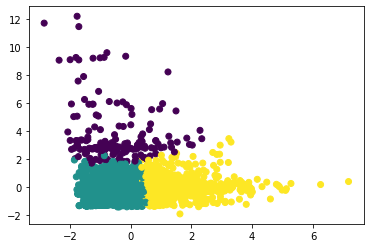

In [60]:
# Let's try arbitrarily 3 clusters 

km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=None)
city_groups_std['cluster'] = km.fit_predict(city_groups_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
#pca.fit(city_groups[features_to_explore])
city_groups_std['x'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 0]
city_groups_std['y'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 1]
plt.scatter(city_groups_std['x'], city_groups_std['y'], c=city_groups_std['cluster'])
plt.show()

In [61]:
city_groups_std.head()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,cluster,x,y
0,0,-0.660175,0.478134,0.322823,-0.596460,-0.003914,-0.484763,-0.678042,-0.325558,1,0.119105,-0.515901
1,3,0.573092,0.774885,1.089608,-0.320181,-0.003914,-0.199493,0.255082,-0.325558,2,0.951140,-0.138827
2,7,5.115126,0.035705,2.608569,-0.596460,2.476215,-0.104403,-0.678042,-0.325558,2,3.856179,-0.285922
3,14,1.746200,-0.444493,2.203459,-0.596460,-0.830623,-0.104403,0.721644,-0.325558,2,1.065450,-0.085451
4,21,0.783650,-0.536216,0.229587,-0.596460,0.822796,-0.865123,1.188206,-0.325558,1,0.457189,-0.527191


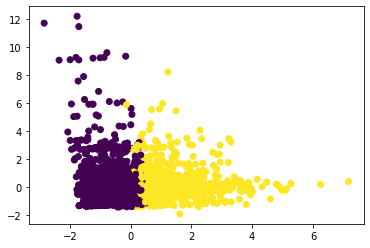

In [62]:
#Let's try it now with 2 clusters

km = cluster.KMeans(n_clusters=2, max_iter=300, random_state=None)
city_groups_std['cluster'] = km.fit_predict(city_groups_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
city_groups_std['x'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 0]
city_groups_std['y'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 1]
plt.scatter(city_groups_std['x'], city_groups_std['y'], c=city_groups_std['cluster'])
plt.show()

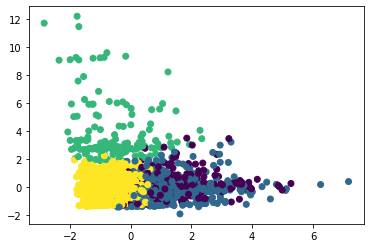

In [63]:
# Now with 4

km = cluster.KMeans(n_clusters=4, max_iter=300, random_state=None)
city_groups_std['cluster'] = km.fit_predict(city_groups_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)

city_groups_std['x'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 0]
city_groups_std['y'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 1]
plt.scatter(city_groups_std['x'], city_groups_std['y'], c=city_groups_std['cluster'])
plt.show()

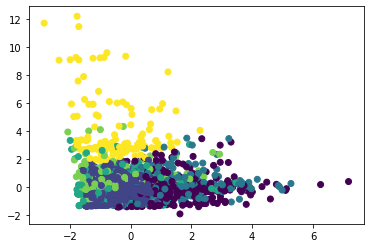

In [64]:
# Now with 6

km = cluster.KMeans(n_clusters=6, max_iter=300, random_state=None)
city_groups_std['cluster'] = km.fit_predict(city_groups_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)

city_groups_std['x'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 0]
city_groups_std['y'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 1]
plt.scatter(city_groups_std['x'], city_groups_std['y'], c=city_groups_std['cluster'])
plt.show()

Let's attempt to use the Elbow Method

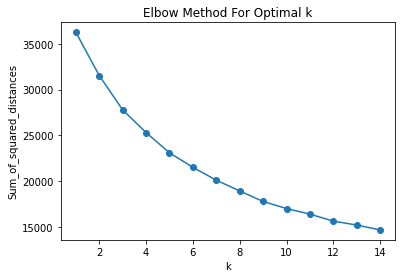

In [65]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []

# Use k from 1 to 15
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=300, random_state=None)
    km = km.fit(city_groups_std[features_to_explore])
    # Get sum of square distances by applying km.inertia_ 
    Sum_of_squared_distances.append(km.inertia_)

# Plot Results
plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Let's try to use the Silhouette Coefficient

In [66]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(city_groups_std[features_to_explore])
    label = kmeans.labels_
    sil_coeff = silhouette_score(city_groups_std[features_to_explore], label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.23211813296821313
For n_clusters=3, The Silhouette Coefficient is 0.2707075805365758
For n_clusters=4, The Silhouette Coefficient is 0.2519059135620243
For n_clusters=5, The Silhouette Coefficient is 0.2614062999886911
For n_clusters=6, The Silhouette Coefficient is 0.26899325259985923
For n_clusters=7, The Silhouette Coefficient is 0.15043083308738908
For n_clusters=8, The Silhouette Coefficient is 0.16831648304495106
For n_clusters=9, The Silhouette Coefficient is 0.1708356098685577
For n_clusters=10, The Silhouette Coefficient is 0.177461176591996


Let's stick with K=3

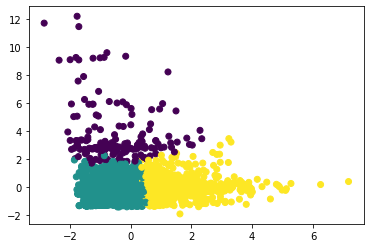

In [67]:
km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=None)
city_groups_std['cluster'] = km.fit_predict(city_groups_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(city_groups[features_to_explore])
city_groups_std['x'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 0]
city_groups_std['y'] = pca.fit_transform(city_groups_std[features_to_explore])[:, 1]
plt.scatter(city_groups_std['x'], city_groups_std['y'], c=city_groups_std['cluster'])
plt.show()

#### Step 4: Profile and Inspect our 3 clusters

In [68]:
# We will merge the two dataframes based on a common column user_location_city
city_groups.merge(city_groups_std[['user_location_city', 'cluster']]).groupby('cluster').mean() # for every column

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
cluster,,,,,,,,,
0,30907.850932,3.042961,55.256884,1540.887311,0.136077,0.187474,4.189130,0.562474,2.447412
1,28042.830281,2.754668,41.145611,1347.123366,0.143644,0.177620,1.982838,0.367094,1.072500
2,28979.252285,5.267879,102.022495,3178.690926,0.108672,0.480847,2.013434,0.322702,1.068302


In [69]:
city_groups_std.head()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,cluster,x,y
0,0,-0.660175,0.478134,0.322823,-0.596460,-0.003914,-0.484763,-0.678042,-0.325558,1,0.119105,-0.515901
1,3,0.573092,0.774885,1.089608,-0.320181,-0.003914,-0.199493,0.255082,-0.325558,2,0.951140,-0.138827
2,7,5.115126,0.035705,2.608569,-0.596460,2.476215,-0.104403,-0.678042,-0.325558,2,3.856179,-0.285922
3,14,1.746200,-0.444493,2.203459,-0.596460,-0.830623,-0.104403,0.721644,-0.325558,2,1.065450,-0.085451
4,21,0.783650,-0.536216,0.229587,-0.596460,0.822796,-0.865123,1.188206,-0.325558,1,0.457189,-0.527191


In [70]:
city_groups_std['cluster'].unique()

array([1, 2, 0], dtype=int32)

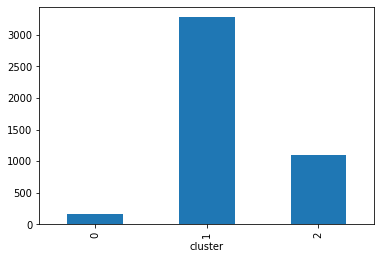

In [71]:
# Plot our Cluster Counts
city_groups_std.groupby('cluster')['user_location_city'].agg('count').plot(kind='bar')

In [72]:
city_groups_std[features_to_explore].shape

(4531, 8)